In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from utils import setup_seed
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("ggplot")
plt.rcParams["font.sans-serif"] = ["Maple Mono NF CN"]

In [67]:
# -------------------------
# 1. DeepReLUNet
# -------------------------


class DeepReLUNet(nn.Module):
    def __init__(self, depth=5, width=512):
        super().__init__()
        layers = []
        layers.append(nn.Linear(32 * 32 * 3, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x, return_feat=False):
        x = x.view(x.size(0), -1)
        z = None
        h = x
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                h = layer(h)
            elif isinstance(layer, nn.ReLU):
                h = layer(h)
                z = h
        if return_feat:
            return h, z
        return h

In [68]:
# -------------------------
# 2. PACR Loss (batch-wise)
# -------------------------
def pacr_loss(features, labels):
    """
    features: (B, D)
    labels:   (B,)
    """
    loss = 0.0
    num_classes = labels.max().item() + 1
    eps = 1e-8

    for c in range(num_classes):
        idx = labels == c
        if idx.sum() < 2:
            continue
        z = features[idx]  # (Nc, D)
        mean = z.mean(dim=0, keepdim=True)
        loss += ((z - mean) ** 2).sum(dim=1).mean()

    return loss / (num_classes + eps)


def pacr_loss_lipschitz_fast(features, logits, labels):
    eps = 1e-6

    # pairwise distances
    dz = torch.cdist(features, features, p=2)
    dy = torch.cdist(logits, logits, p=2)

    label_eq = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = torch.triu(label_eq, diagonal=1)

    ratio = dy / (dz + eps)
    loss = (ratio[mask] ** 2).mean()

    return loss


In [69]:
# -------------------------
# 3. Training / Evaluation
# -------------------------
def train_epoch(model, loader, optimizer, device, lambda_pacr=0.0):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, feats = model(x, return_feat=True)
        loss_ce = F.cross_entropy(logits, y)

        loss = loss_ce
        if lambda_pacr > 0:
            loss_pacr = pacr_loss_lipschitz_fast(feats, logits, y)
            loss = loss + lambda_pacr * loss_pacr

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


In [70]:
@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_correct, total = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_correct / total


In [71]:
# -------------------------
# 4. Main Experiment
# -------------------------
def main(lambda_pacr=0.0):
    info = {"train_acc": [], "test_acc": []}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    transform_test = transforms.Compose([transforms.ToTensor()])

    train_set = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    test_set = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_set, batch_size=1280, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=256)

    model = DeepReLUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    for epoch in tqdm(range(1, 51)):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, device, lambda_pacr
        )
        test_acc = eval_epoch(model, test_loader, device)
        info["train_acc"].append(train_acc)
        info["test_acc"].append(test_acc)
        # print(
        #     f"Epoch {epoch:03d} | "
        #     f"Loss {train_loss:.4f} | "
        #     f"Train Acc {train_acc:.3f} | "
        #     f"Test Acc {test_acc:.3f}"
        # )
    return info


In [72]:
setup_seed(42)
ainfo = main(lambda_pacr=0.001)
setup_seed(42)
oinfo = main(lambda_pacr=0.0)


100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


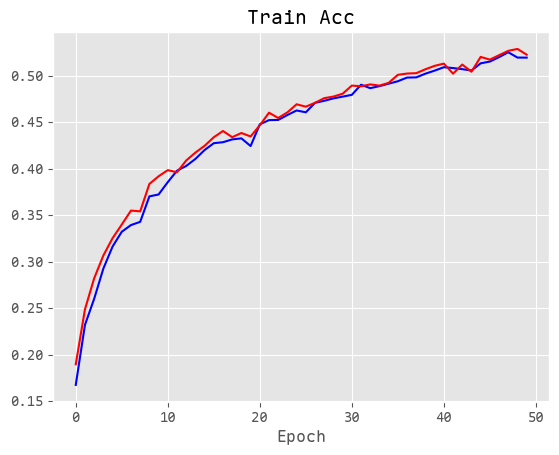

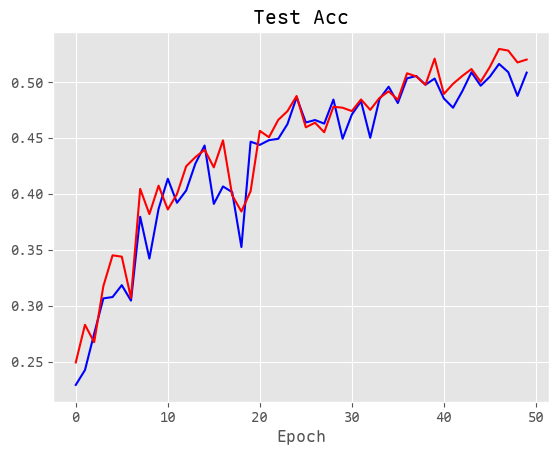

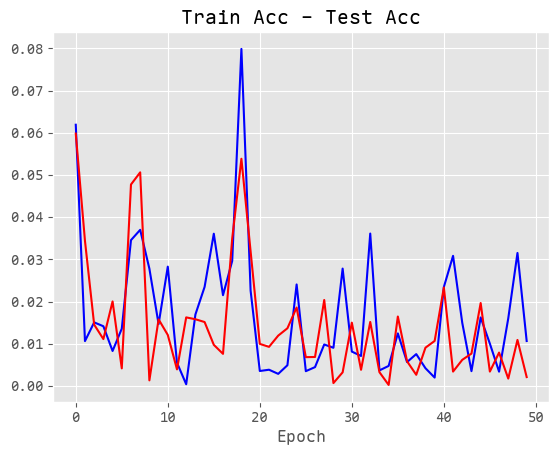

In [81]:
fig, ax = plt.subplots()
ax.plot(oinfo["train_acc"], "b-")
ax.plot(ainfo["train_acc"], "r-")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(oinfo["test_acc"], "b-")
ax.plot(ainfo["test_acc"], "r-")
ax.set_xlabel("Epoch")
ax.set_title("Test Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(np.abs(np.array(oinfo["train_acc"]) - np.array(oinfo["test_acc"])), "b")
ax.plot(np.abs(np.array(ainfo["train_acc"]) - np.array(ainfo["test_acc"])), "r")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc - Test Acc")
plt.show()

In [74]:
np.max(oinfo["test_acc"]), np.max(ainfo["test_acc"])

(np.float64(0.5165), np.float64(0.5299))

In [75]:
np.mean(oinfo["test_acc"]), np.mean(ainfo["test_acc"])


(np.float64(0.433188), np.float64(0.44336))

In [76]:
ogap = np.abs(np.array(oinfo["train_acc"]) - np.array(oinfo["test_acc"]))
agap = np.abs(np.array(ainfo["train_acc"]) - np.array(ainfo["test_acc"]))
np.mean(ogap), np.mean(agap)

(np.float64(0.016970000000000006), np.float64(0.014623200000000001))

In [77]:
np.max(ogap), np.max(agap)


(np.float64(0.07985999999999999), np.float64(0.05979999999999999))

In [78]:
np.min(ogap), np.min(agap)


(np.float64(0.00041999999999997595), np.float64(0.00025999999999998247))

In [82]:
np.var(ogap), np.var(agap)


(np.float64(0.00023612856399999975), np.float64(0.00019445531776))